In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

## Additional analysis
### Creating PCA of normalised CTRP-L1000 data and t-SNE

In [ ]:
#functions needed for this part
from sklearn.decomposition import PCA
from MulticoreTSNE import MulticoreTSNE as TSNE
from scipy.stats import spearmanr as scor
from sklearn.metrics import silhouette_score

from other_functions import *

In [17]:
sig_info=pd.read_table('../results/CTRP/sig_info_merged_lm.csv',
                       sep=',',header=0,index_col=[0])
signatures=pd.read_table('../results/CTRP/signatures_merged_lm.csv',
                         sep=',',header=0,index_col=[0])

In [18]:
# gene and sample wise normalisation
signatures_gene_norm=(signatures-np.mean(signatures))/np.std(signatures)
signatures_samp_norm=((signatures.T-np.mean(signatures,1))/np.std(signatures,1)).T

In [19]:
#do the pca
model=PCA(2,random_state=19890904)
signatures_pca=pd.DataFrame(model.fit_transform(signatures_gene_norm),
                            index=signatures_gene_norm.index)
evr1,evr2=model.explained_variance_ratio_.round(3).astype(str)
signatures_pca.columns=['PC1\nexplained variance ratio: '+evr1,
                      'PC2\nexplained variance ratio: '+evr2]
signatures_pca.to_csv('../results/model/dimension_reduction/pca_gene.csv',
                      sep=',')
signatures_pca=pd.DataFrame(model.fit_transform(signatures_samp_norm),
                            index=signatures_samp_norm.index)
evr1,evr2=model.explained_variance_ratio_.round(3).astype(str)
signatures_pca.columns=['PC1\nexplained variance ratio: '+evr1,
                      'PC2\nexplained variance ratio: '+evr2]
signatures_pca.to_csv('../results/model/dimension_reduction/pca_sample.csv',
                      sep=',')

In [16]:
#we can do also do for dimensionality reduction t-SNE, with different perplexities
#takes some time
perplexities=[10,20,50,100]
for perp in perplexities:
    model=TSNE(n_components=2,perplexity=perp,n_jobs=8,random_state=19890904)
    signatures_tsne=pd.DataFrame(model.fit_transform(signatures),
                                 index=signatures.index,columns=['Dim1','Dim2'])
    signatures_tsne.to_csv('../results/model/dimension_reduction/tsne_%i.csv' % perp,
                          sep=',')
    signatures_tsne=pd.DataFrame(model.fit_transform(signatures_gene_norm),
                                 index=signatures_gene_norm.index,columns=['Dim1','Dim2'])
    signatures_tsne.to_csv('../results/model/dimension_reduction/tsne_gene_%i.csv' % perp,
                          sep=',')
    signatures_tsne=pd.DataFrame(model.fit_transform(signatures_samp_norm),
                                 index=signatures_samp_norm.index,columns=['Dim1','Dim2'])
    signatures_tsne.to_csv('../results/model/dimension_reduction/tsne_sample_%i.csv' % perp,
                          sep=',')

Spearman Rho with X: SpearmanrResult(correlation=-0.23042528242680105, pvalue=2.084640582721842e-224)
Spearman Rho with Y: SpearmanrResult(correlation=-0.23598557933827391, pvalue=1.395465496038267e-235)


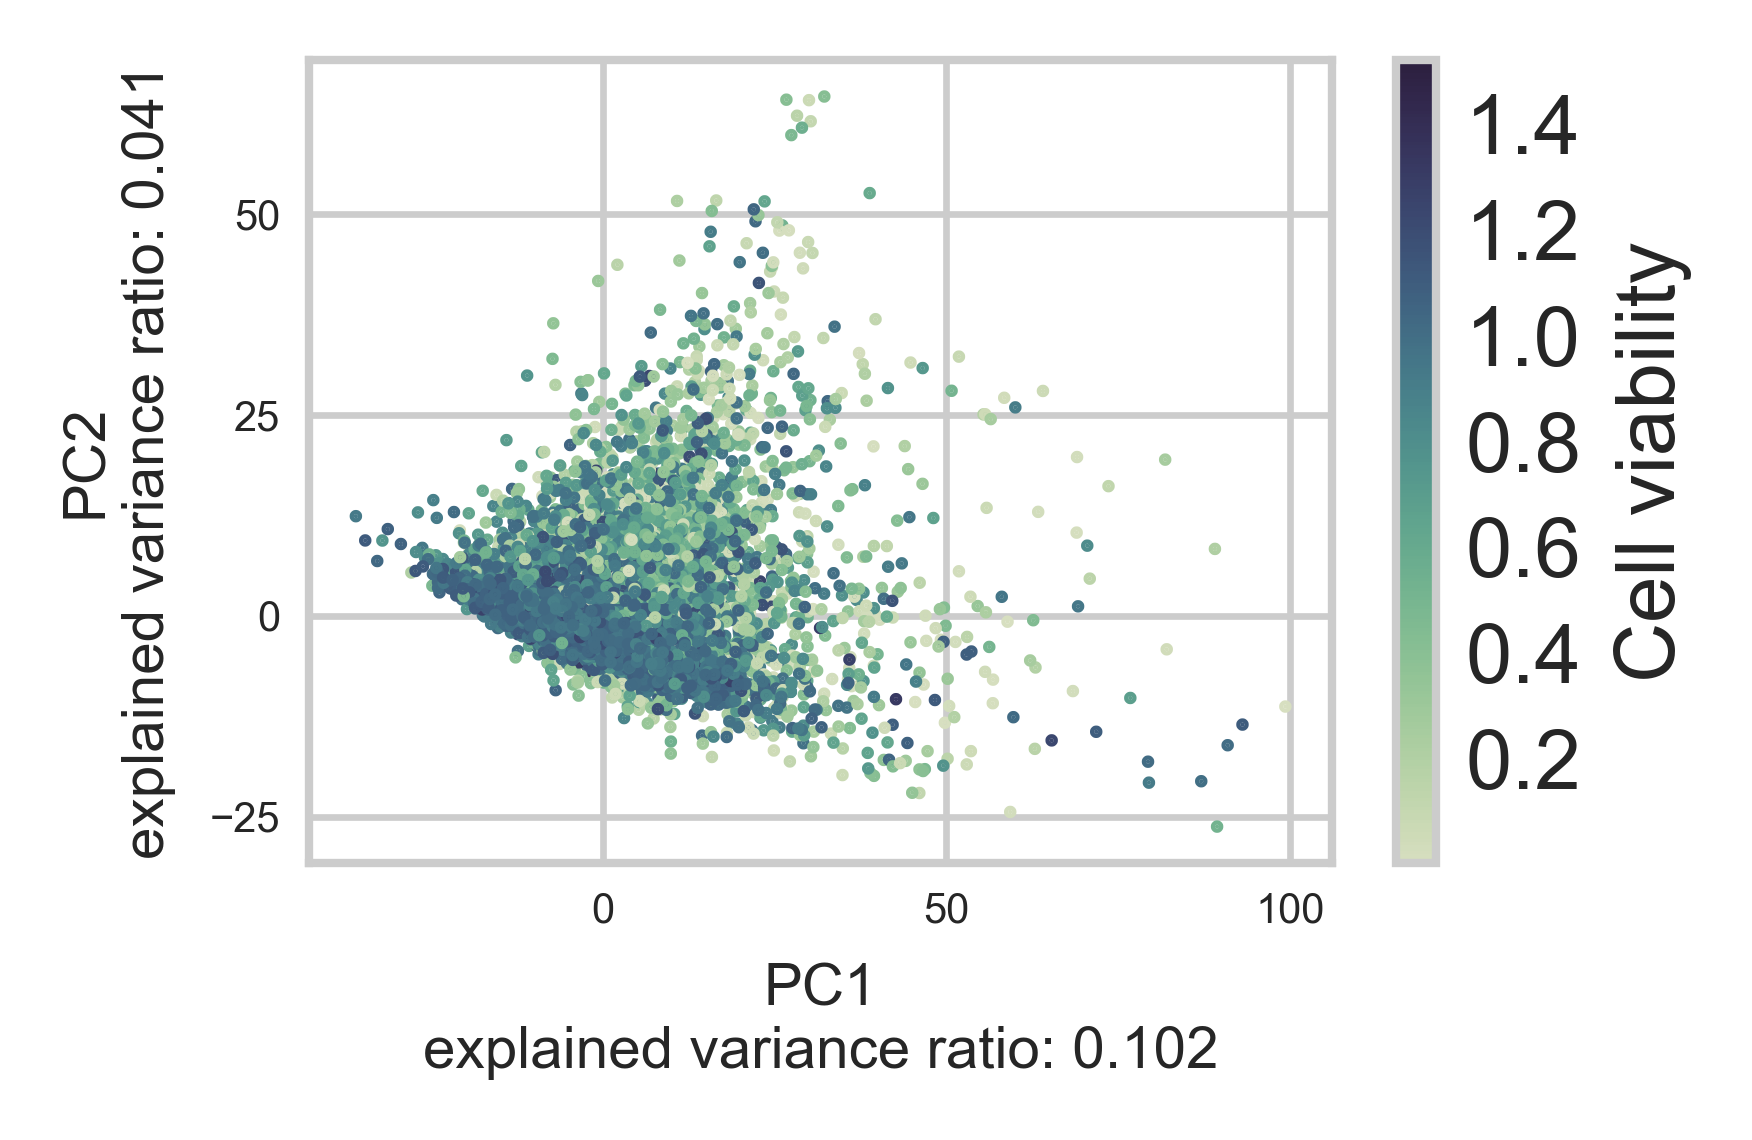

In [22]:
#let's make a PCA of gene wise normalized signautres
#it is not very different from not normalized signatures
#as we already used z scores
sig_data=pd.read_table('../results/model/dimension_reduction/pca_gene.csv',
                       sep=',',header=0,index_col=[0])
sig_info=pd.read_table('../results/CTRP/sig_info_merged_lm.csv',
                       sep=',',header=0,index_col=[0])
make_dim_reduc_plot(sig_data,sig_info)

Spearman Rho with X: SpearmanrResult(correlation=0.18130760601063828, pvalue=2.7901576288003937e-138)
Spearman Rho with Y: SpearmanrResult(correlation=-0.35586253009114494, pvalue=0.0)


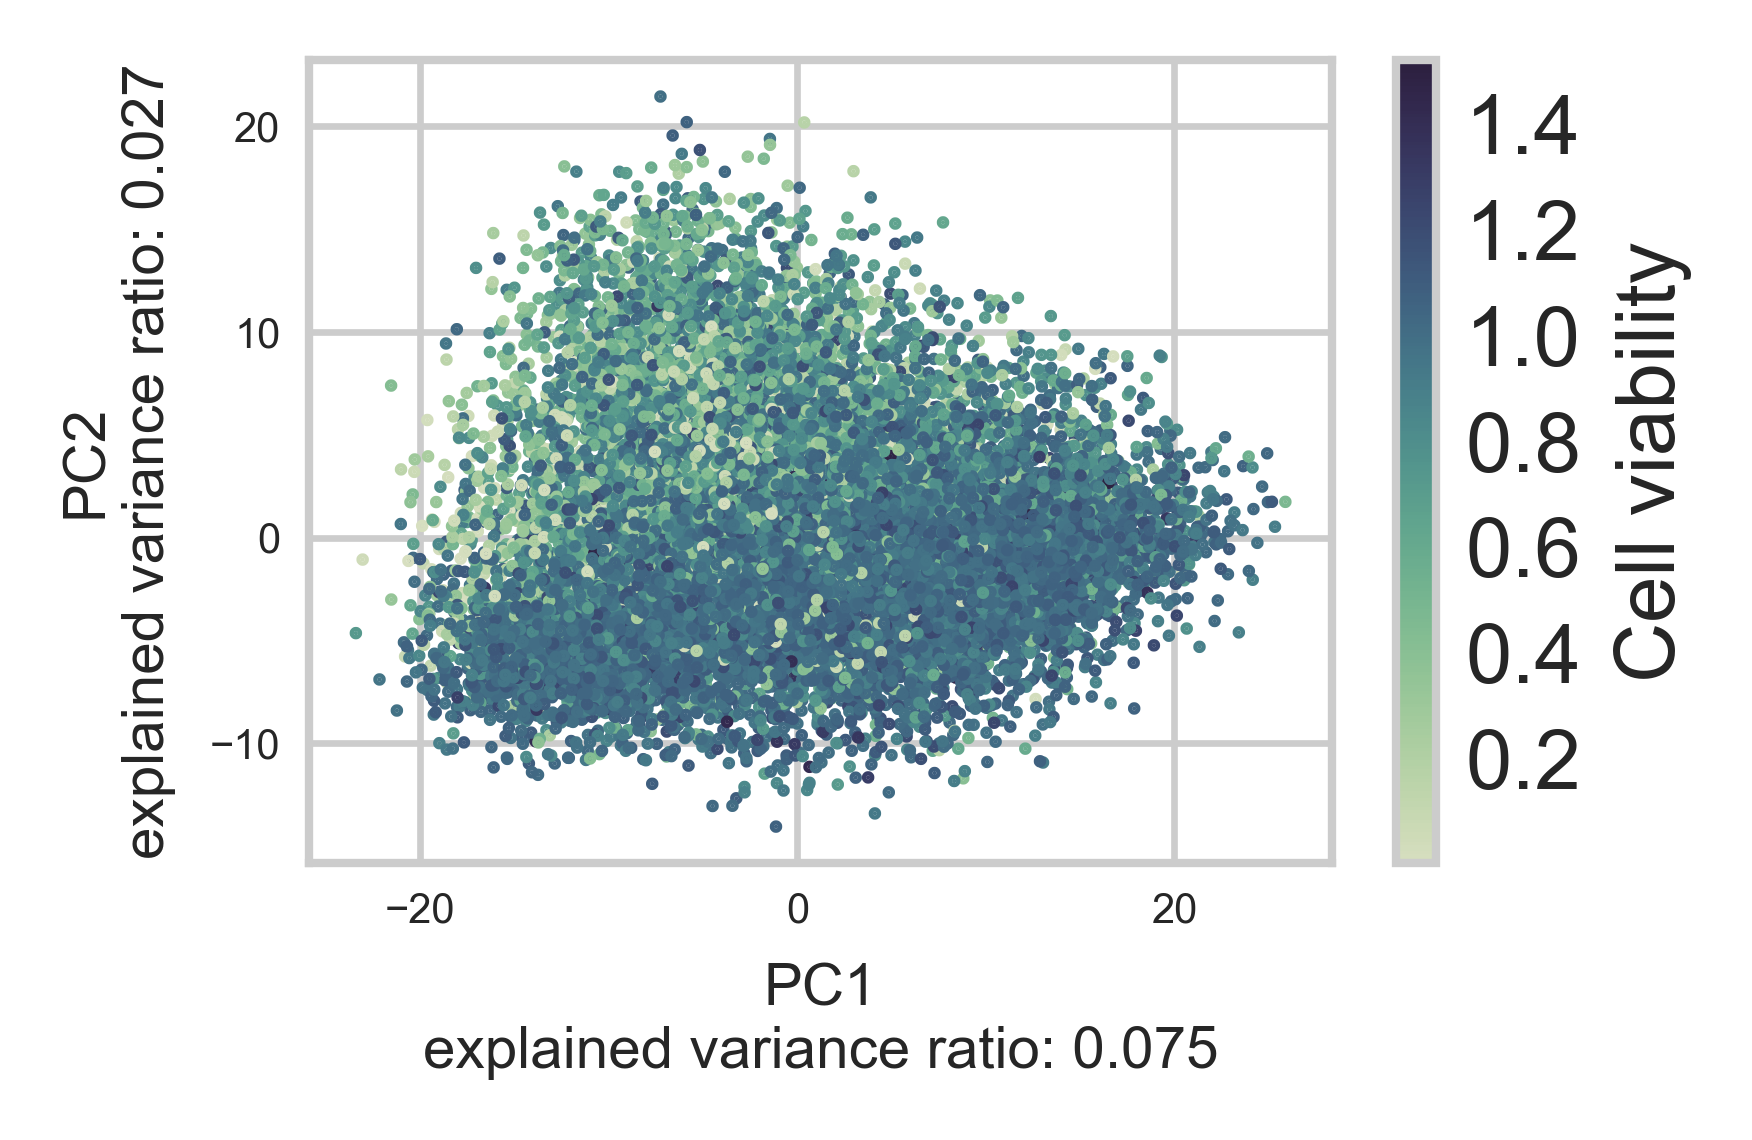

In [23]:
#let's make a PCA of sample wise normalized signautres
sig_data=pd.read_table('../results/model/dimension_reduction/pca_sample.csv',
                       sep=',',header=0,index_col=[0])
sig_info=pd.read_table('../results/CTRP/sig_info_merged_lm.csv',
                       sep=',',header=0,index_col=[0])
make_dim_reduc_plot(sig_data,sig_info,fname='sample_pca_viab')

Spearman Rho with X: SpearmanrResult(correlation=0.20021664612598844, pvalue=8.3950793225189746e-169)
Spearman Rho with Y: SpearmanrResult(correlation=-0.26335367478725047, pvalue=5.7124795312809883e-295)


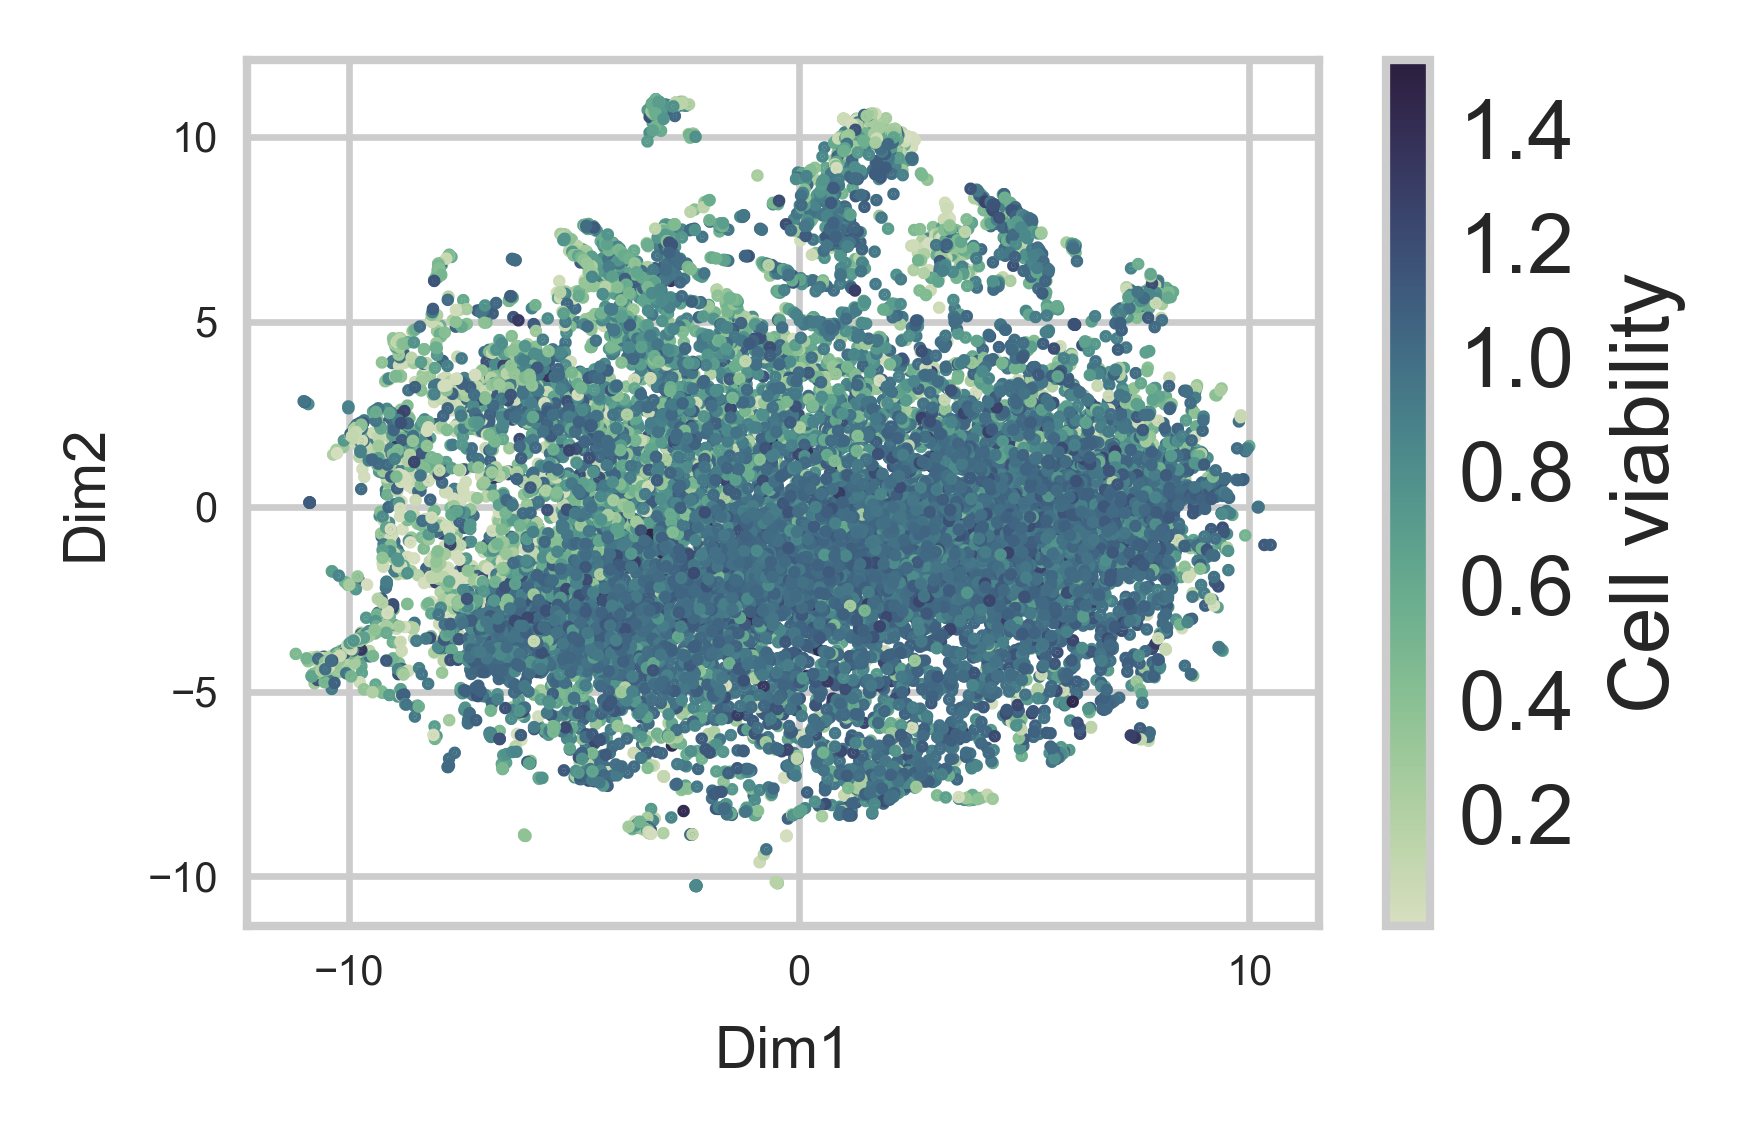

In [24]:
#let's make a t-SNE plot
sig_data=pd.read_table('../results/model/dimension_reduction/tsne_100.csv',
                       sep=',',header=0,index_col=[0])
sig_info=pd.read_table('../results/CTRP/sig_info_merged_lm.csv',
                       sep=',',header=0,index_col=[0])
sig_info['bin_viability']='Cell viability<=0.8'
fil=sig_info['cpd_avg_pv']>0.8
sig_info.loc[sig_info.index[fil],'bin_viability']='Cell viability>0.8'
make_dim_reduc_plot(sig_data,sig_info,color_by='viability',fname='tsne_viability')

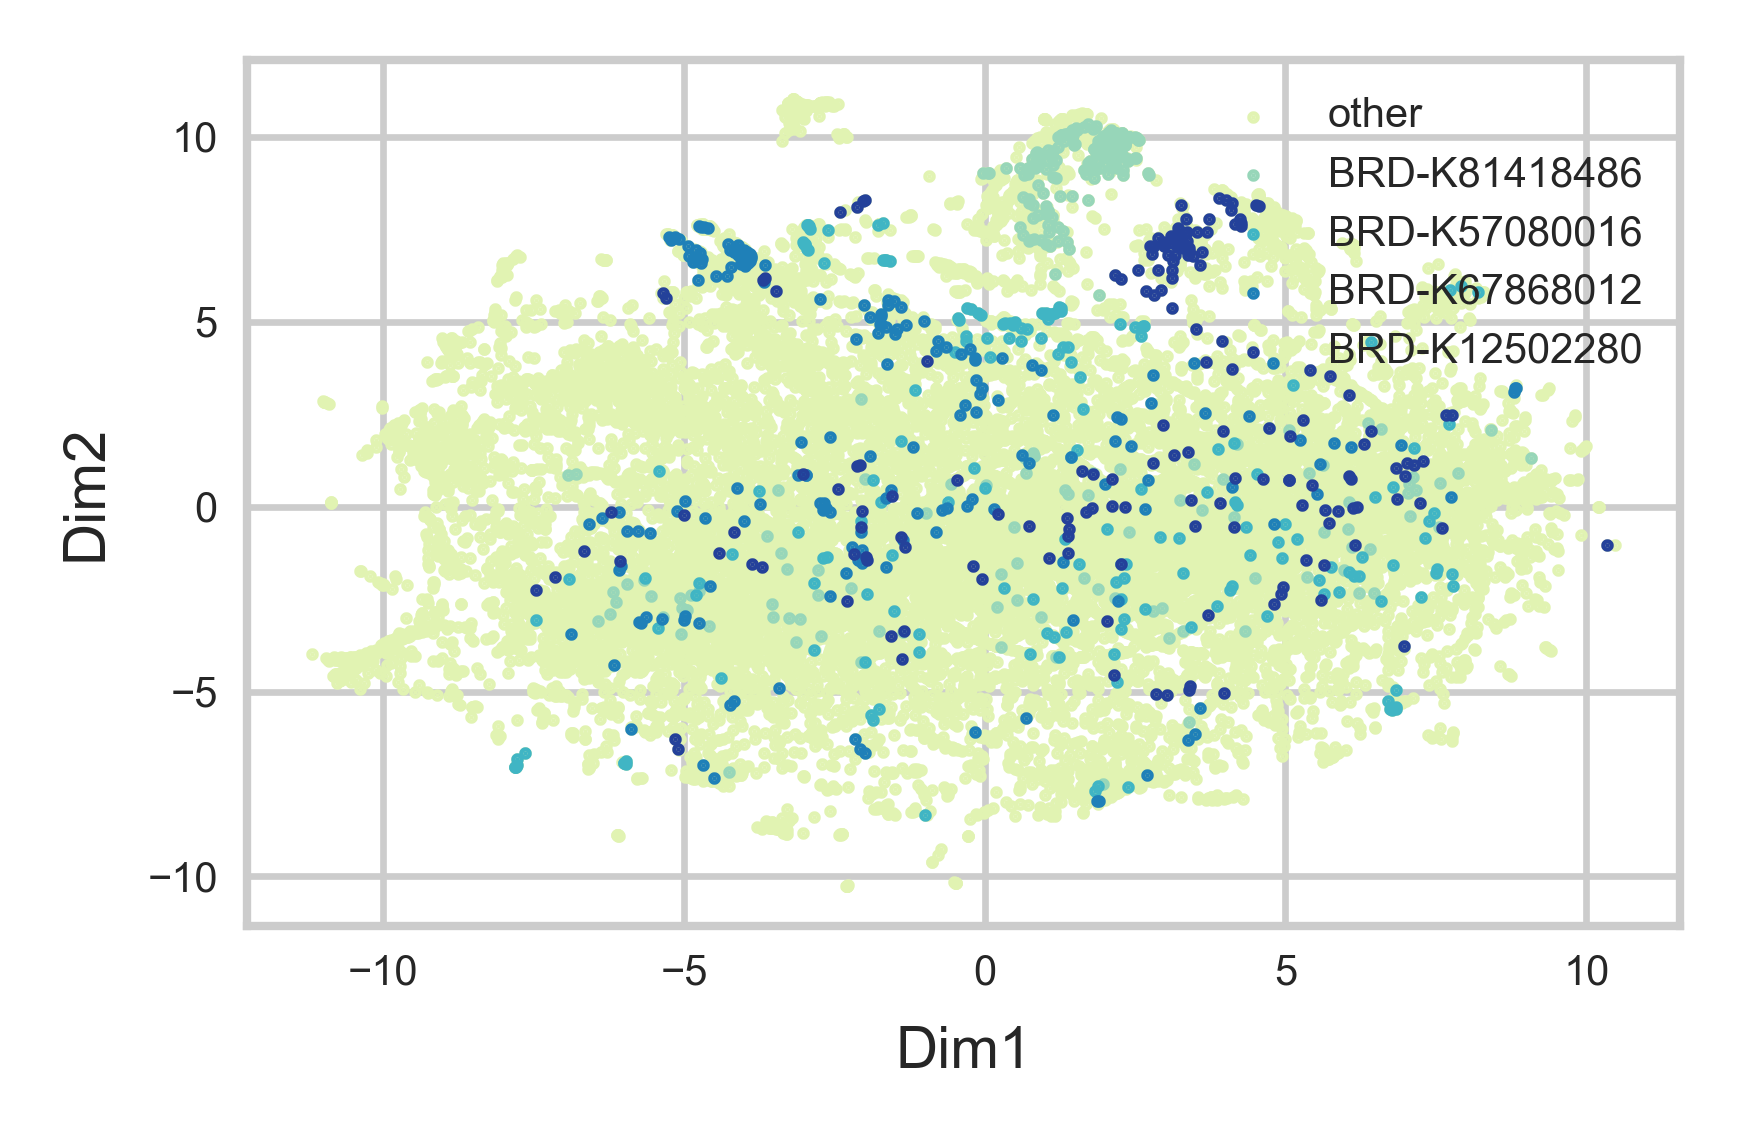

In [25]:
make_dim_reduc_plot(sig_data,sig_info,color_by='pert_id',fname='tsne_perturbation')

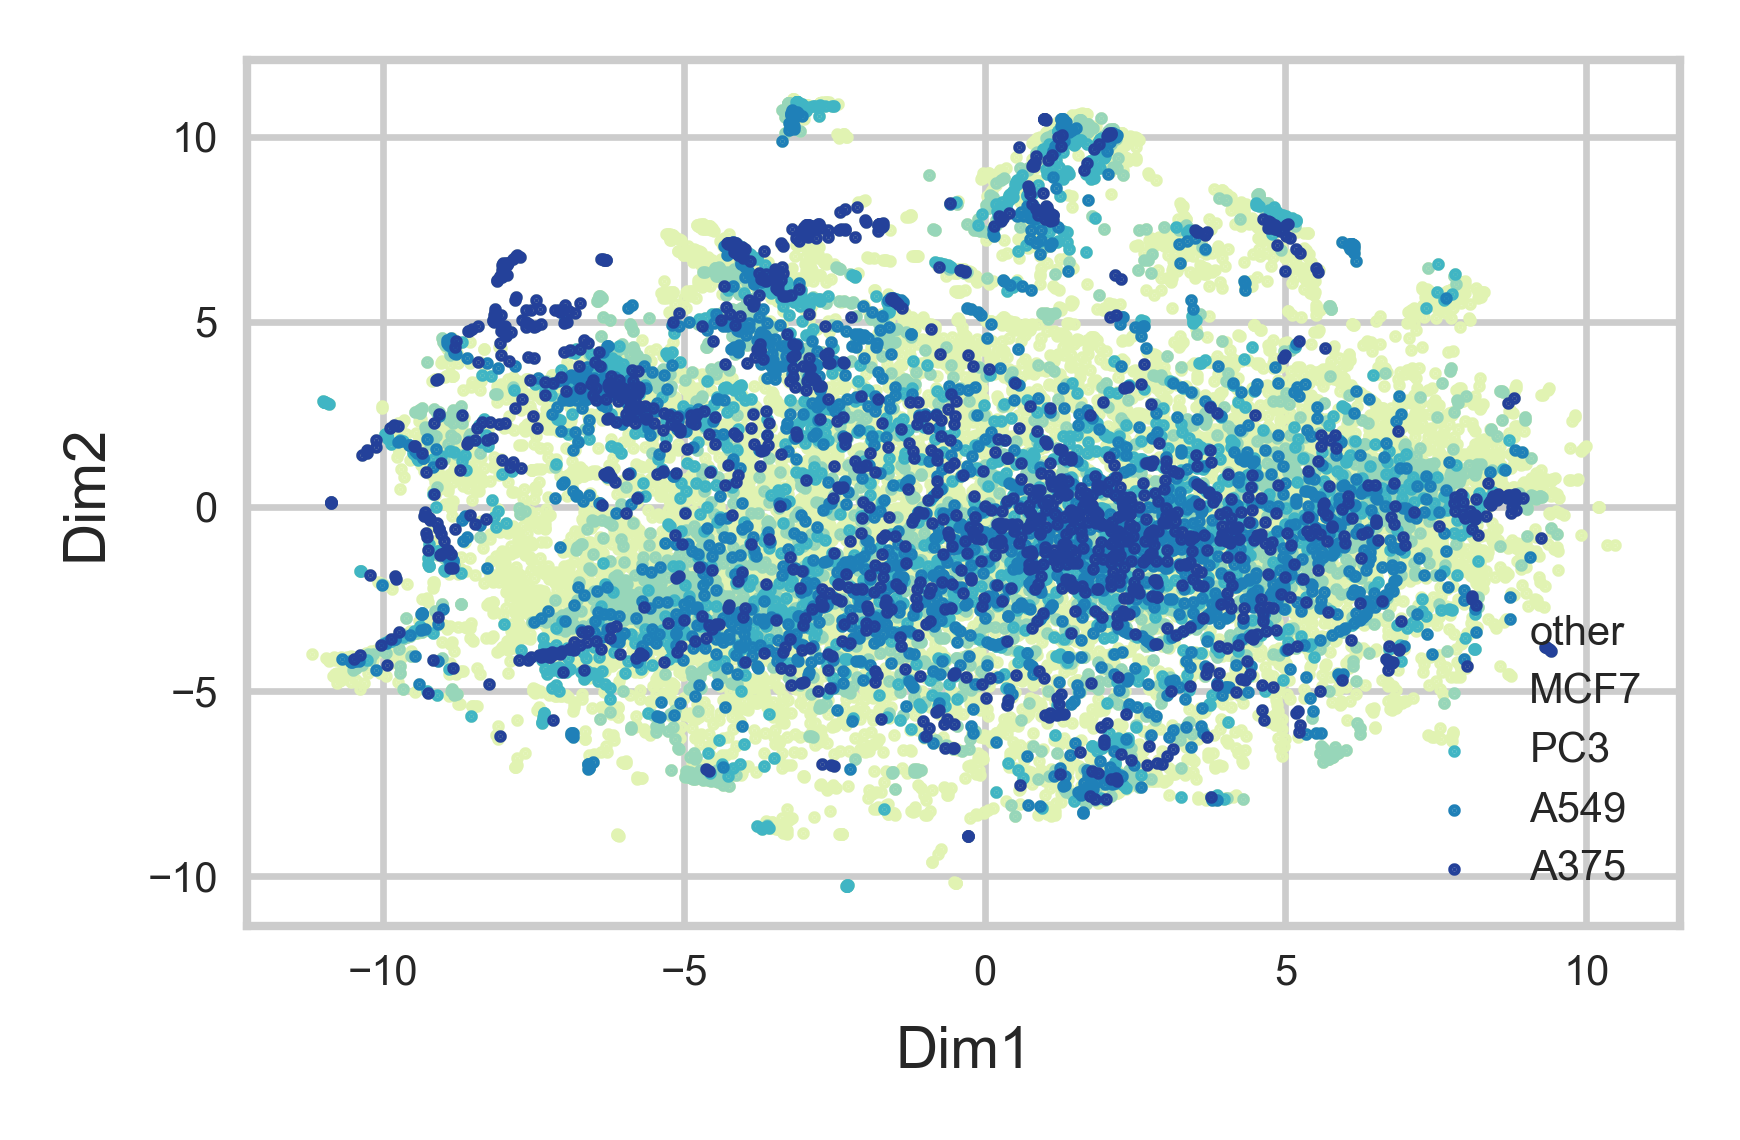

In [26]:
make_dim_reduc_plot(sig_data,sig_info,color_by='cell_id',fname='tsne_cell')

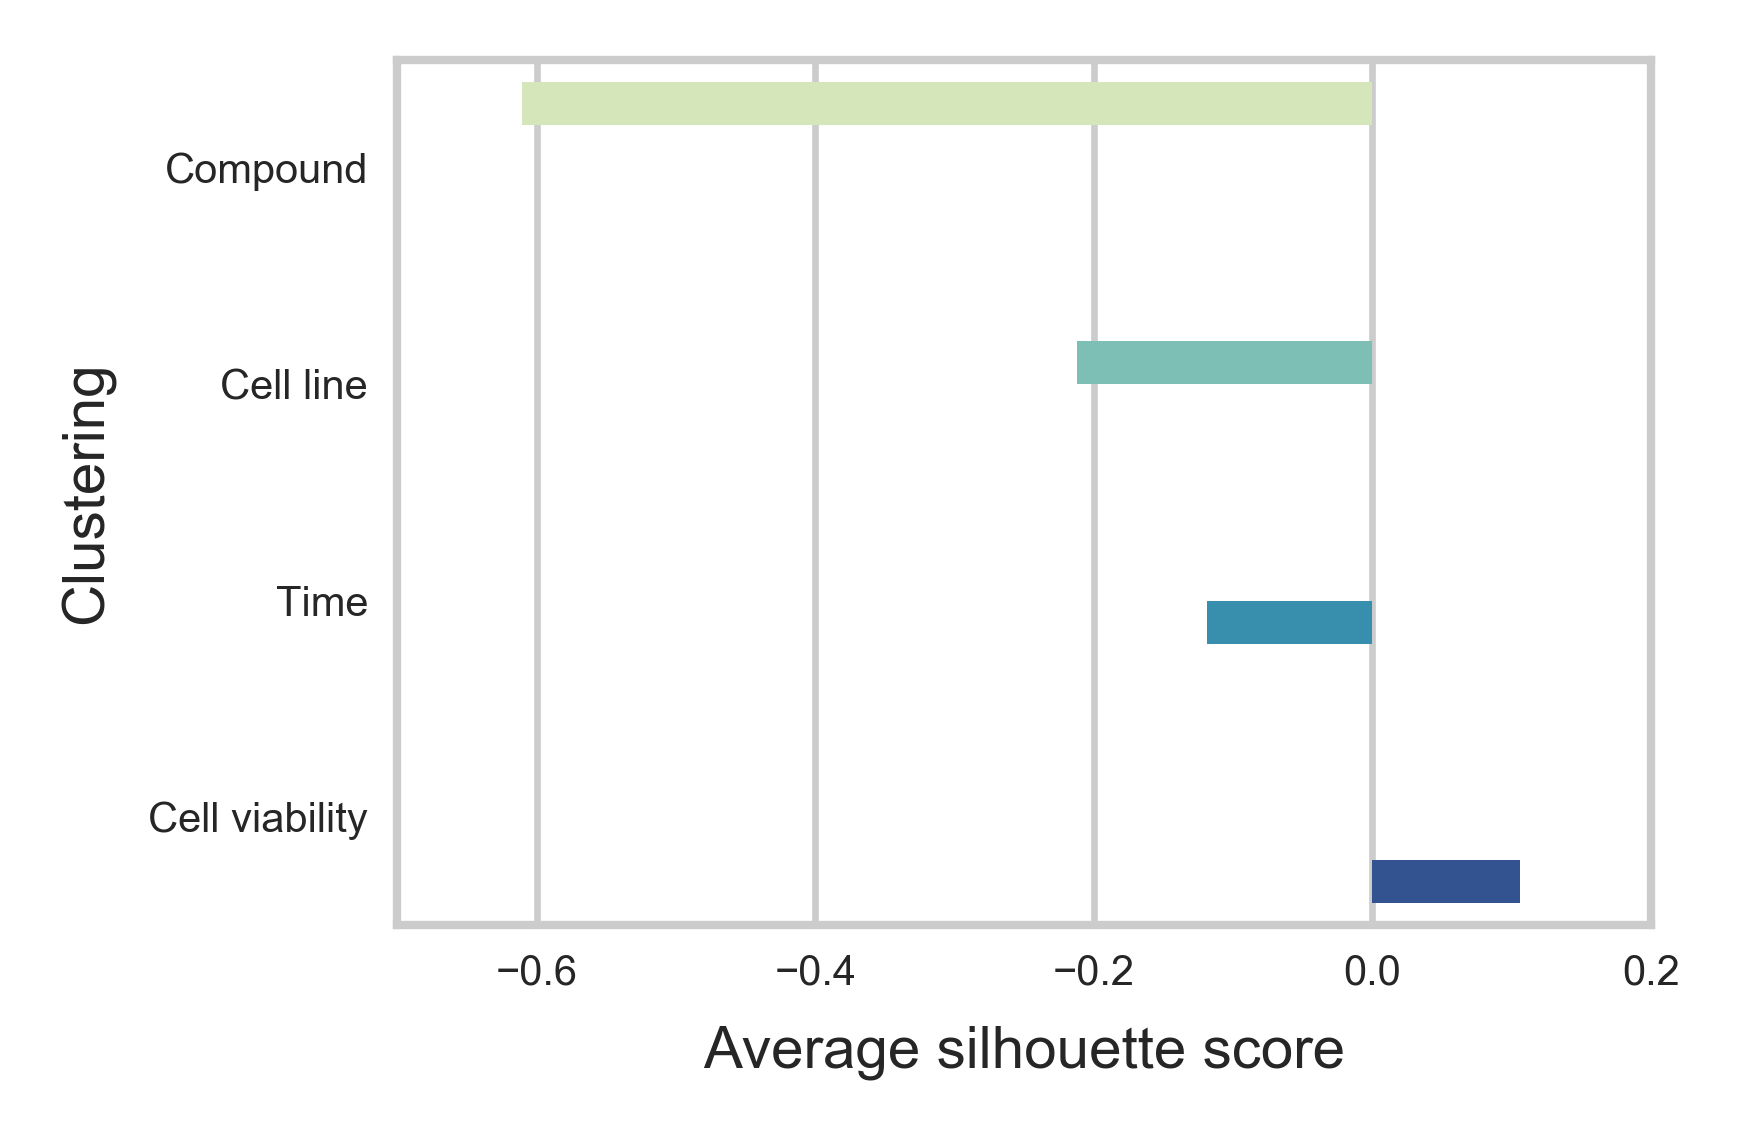

In [29]:
sig_clustering=sig_info.loc[:,['pert_id','cell_id','bin_viability','pert_itime']].copy()
sig_clustering['PC1']=sig_data.iloc[:,0]
sig_clustering['PC2']=sig_data.iloc[:,1]
sns.set_palette('YlGnBu',4)
clustering_results=pd.DataFrame(index=range(4),columns=['Clustering',
                                                        'Clustering\nbased on','Average silhouette'])
clustering_results.loc[0,:]=['Compound','Compound',
                             silhouette_score(sig_clustering.loc[:,['PC1','PC2']],sig_clustering['pert_id'])]
clustering_results.loc[1,:]=['Cell line','Cell line',
                             silhouette_score(sig_clustering.loc[:,['PC1','PC2']],sig_clustering['cell_id'])]
clustering_results.loc[2,:]=['Time','Time',
                             silhouette_score(sig_clustering.loc[:,['PC1','PC2']],sig_clustering['pert_itime'])]
clustering_results.loc[3,:]=['Cell viability','Cell viability',
                             silhouette_score(sig_clustering.loc[:,['PC1','PC2']],sig_clustering['bin_viability'])]
plt.figure(dpi=600,figsize=(3.0,2.0))
sns.barplot(x='Average silhouette',y='Clustering',hue='Clustering\nbased on',
            data=clustering_results)
plt.xlim(-0.7,0.2)
plt.xticks(size=5)
plt.yticks(size=5)
plt.legend([])
plt.xlabel('Average silhouette score',size=7)
plt.ylabel('Clustering',size=7)
plt.tight_layout()
plt.savefig('../figures/raw/tsne_silhouette.pdf')

### Non linear models and across dataset prediction using classical models

In [73]:
# functions needed for this part
from scipy.stats import pearsonr as pcor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

In [2]:
#just reading the data
SIGNATURES={}
SIG_INFO={}
SIGNATURES['CTRP']=pd.read_table('../results/CTRP/signatures_merged_lm.csv',
                            sep=',',header=0,index_col=[0])
SIGNATURES['Achilles']=pd.read_table('../results/Achilles/signatures_merged_lm.csv',
                            sep=',',header=0,index_col=[0])
SIG_INFO['CTRP']=pd.read_table('../results/CTRP/sig_info_merged_lm.csv',
                            sep=',',header=0,index_col=[0])
SIG_INFO['Achilles']=pd.read_table('../results/Achilles/sig_info_merged_lm.csv',
                            sep=',',header=0,index_col=[0])

In [58]:
def make_prediction_classical(tr='CTRP',cv='CTRP',
                              tr_time='24 h',cv_time='24 h',s=0):
    response_tr=SIG_INFO[tr].copy()
    response_cv=SIG_INFO[cv].copy()
    fil=response_tr['pert_itime']==tr_time
    response_tr=response_tr[fil]
    fil=response_cv['pert_itime']==cv_time
    response_cv=response_cv[fil]
    np.random.seed(s)
    cv_index=list(np.random.choice(response_cv.index,
                                   int(len(response_cv.index)/2),False))
    response_cv=response_cv.loc[cv_index]
    #creates indicator matrix
    if (tr==cv) & (tr_time==cv_time):
        tr_index=list(set(response_tr.index)-set(response_cv.index))
    else:
        tr_index=response_tr.index
    response_tr=response_tr.loc[tr_index]
    cell_lines=list(set(response_cv['cell_id'])|set(response_tr['cell_id']))
    cell_features=pd.DataFrame(np.identity(len(cell_lines),int),
                               index=cell_lines,columns=cell_lines)
    perts=list(set(response_tr['pert_id'])|set(response_cv['pert_id']))
    pert_features=pd.DataFrame(np.identity(len(perts),int),
                               index=perts,columns=perts)
    cell_features_tr=cell_features.loc[response_tr['cell_id'].values]
    cell_features_tr.index=response_tr.index
    cell_features_cv=cell_features.loc[response_cv['cell_id'].values]
    cell_features_cv.index=response_cv.index
    pert_features_tr=pert_features.loc[response_tr['pert_id'].values]
    pert_features_tr.index=response_tr.index
    pert_features_cv=pert_features.loc[response_cv['pert_id'].values]
    pert_features_cv.index=response_cv.index
    features_tr=pd.concat([cell_features_tr,pert_features_tr],1)
    features_cv=pd.concat([cell_features_cv,pert_features_cv],1)
    if tr=='CTRP':
        features_tr['log10_cpd_conc_umol']=response_tr['log10_cpd_conc_umol']
    else:
        features_tr['log10_cpd_conc_umol']=0
    if cv=='CTRP':
        features_cv['log10_cpd_conc_umol']=response_cv['log10_cpd_conc_umol']
    else:
        features_cv['log10_cpd_conc_umol']=0
    
    #setting response variable (variable to fit model on / to predict)
    if tr=='CTRP':
        resp_variable_tr='cpd_avg_pv'
    else:
        resp_variable_tr='shRNA_abundance'
    if cv=='CTRP':
        resp_variable_cv='cpd_avg_pv'
    else:
        resp_variable_cv='shRNA_abundance'
    
    
    #train and evaluate model
    model=Ridge()
    model.fit(features_tr,response_tr[resp_variable_tr])
    y_pr=model.predict(features_cv)
    y=response_cv[resp_variable_cv].values
    r,p=pcor(y_pr,y)
    return r,p

In [72]:
r1,p1=make_prediction_classical(tr='CTRP',cv='Achilles',
                              tr_time='24 h',cv_time='96 h',s=0)
r2,p2=make_prediction_classical(tr='Achilles',cv='CTRP',
                              tr_time='96 h',cv_time='24 h',s=0)
print('Across dataset predictions:')
print('From CTRP to Achilles, r=',r1,' p=',p1)
print('From Achilles to CTRP, r=',r2,' p=',p2)

Across dataset predictions:
From CTRP to Achilles, r= -0.012016714753  p= 0.0413541249988
From Achilles to CTRP, r= -0.143083575673  p= 9.5083097602e-24


As you can see, classical models are useless in case of across model predictions. Interestingly training models on Achilles and prediciting CTRP leads toweak (but significant) negative correlation, which is probably based on some generall, cell type specific effect (but needs further analysis).

We can also try non-linear prediction methods (in this case Random Forest Regression).

In [81]:
def make_prediction_with_cv_dif_model(model,tr='CTRP',cv='CTRP',
                        tr_time='24 h',cv_time='24 h',s=0):
    """makes prediction for CTRP / Achilles cell viability / shRNA abundance
    based on L1000 signatures. tr and cv are training and cv datasets, while 
    tr_time and cv_time are the perturbattion times to be used. Uses signatures
    and sig_info global variables.""" 
    #reading data and make tr/cv split
    features=SIGNATURES[cv].copy()
    response=SIG_INFO[cv].copy()
    if cv_time!='all':
        fil=response['pert_itime']==cv_time
    else:
        fil=response['pert_itime']!=cv_time
    features_cv=features[fil]
    response_cv=response[fil]
    np.random.seed(s)
    cv_index=list(np.random.choice(features_cv.index,int(len(features_cv.index)/2),False))
    if tr==cv:
        if tr_time!='all':
            fil=response['pert_itime']==tr_time
        else:
            fil=response['pert_itime']!=tr_time
        features_tr=features[fil]
        response_tr=response[fil]
        tr_index=list(set(features_tr.index)-set(cv_index))
    else:
        features=SIGNATURES[tr].copy()
        features=features.loc[:,features_cv.columns]
        response=SIG_INFO[tr].copy()
        if tr_time!='all':
            fil=response['pert_itime']==tr_time
        else:
            fil=response['pert_itime']!=tr_time
        features_tr=features[fil]
        response_tr=response[fil]
        tr_index=list(set(features_tr.index)-set(cv_index))
    features_tr=features_tr.loc[tr_index,:]
    response_tr=response_tr.loc[tr_index,:]
    features_cv=features_cv.loc[cv_index,:]
    response_cv=response_cv.loc[cv_index,:]
    
    #setting response variable (variable to fit model on / to predict)
    if tr=='CTRP':
        tr_variable='cpd_avg_pv'
    if tr=='Achilles':
        tr_variable='shRNA_abundance'
    if cv=='CTRP':
        cv_variable='cpd_avg_pv'
    if cv=='Achilles':
        cv_variable='shRNA_abundance'
    
    #train and evaluate model
    model.fit(features_tr,response_tr[tr_variable])
    y_pr=model.predict(features_cv)
    y=response_cv[cv_variable].values
    r,p=pcor(y_pr,y)
    return r,p

In [98]:
n_jobs=10 #select the correct one for your CPU
n_trees=[10,20,50,100,200]
rs_achilles=[]
rs_ctrp=[]
rs_across=[]
for n in n_trees:
    print(rs_achilles,rs_ctrp,rs_across)
    r,p=make_prediction_with_cv_dif_model(RandomForestRegressor(n_estimators=n,n_jobs=n_jobs),
                                          tr='CTRP',cv='CTRP',tr_time='24 h',cv_time='24 h',s=0)
    rs_ctrp.append(r)
    r,p=make_prediction_with_cv_dif_model(RandomForestRegressor(n_estimators=n,n_jobs=n_jobs),
                                          tr='Achilles',cv='Achilles',tr_time='96 h',cv_time='96 h',s=0)
    rs_achilles.append(r)
    r,p=make_prediction_with_cv_dif_model(RandomForestRegressor(n_estimators=n,n_jobs=n_jobs),
                                          tr='Achilles',cv='CTRP',tr_time='96 h',cv_time='24 h',s=0)
    rs_across.append(r)

[] [] []
[0.40436670914599981] [0.61997855746371178] [0.46511543756563273]
[0.40436670914599981, 0.44281666687523541] [0.61997855746371178, 0.64696601001032283] [0.46511543756563273, 0.49892642263845077]
[0.40436670914599981, 0.44281666687523541, 0.47180166501489362] [0.61997855746371178, 0.64696601001032283, 0.66687946630826178] [0.46511543756563273, 0.49892642263845077, 0.51930457321946799]
[0.40436670914599981, 0.44281666687523541, 0.47180166501489362, 0.48274440742768127] [0.61997855746371178, 0.64696601001032283, 0.66687946630826178, 0.67051914024609038] [0.46511543756563273, 0.49892642263845077, 0.51930457321946799, 0.52472307749961933]


In [103]:
results=pd.DataFrame(index=n_trees)
results['Achilles']=rs_achilles
results['CTRP']=rs_ctrp
results['Across']=rs_across
results.to_csv('../results/model/cv/random_forest.csv',sep=',')
results

,Achilles,CTRP,Across
10,0.404367,0.619979,0.465115
20,0.442817,0.646966,0.498926
50,0.471802,0.666879,0.519305
100,0.482744,0.670519,0.524723
200,0.489154,0.673259,0.529754


In [101]:
rs_ridge=[]
r,p=make_prediction_with_cv_dif_model(Ridge(),
                                          tr='CTRP',cv='CTRP',tr_time='24 h',cv_time='24 h',s=0)
rs_ridge.append(r)
r,p=make_prediction_with_cv_dif_model(Ridge(),
                                          tr='Achilles',cv='Achilles',tr_time='96 h',cv_time='96 h',s=0)
rs_ridge.append(r)
r,p=make_prediction_with_cv_dif_model(Ridge(),
                                          tr='Achilles',cv='CTRP',tr_time='96 h',cv_time='24 h',s=0)
rs_ridge.append(r)

In [102]:
rs_ridge=pd.Series(rs_ridge,index=['CTRP','Achilles','Across'])
rs_ridge

CTRP        0.640031
Achilles    0.520419
Across      0.525972
dtype: float64

In [129]:
def plot_nonlinear_performance(setting):
    plt.figure(dpi=600,figsize=(3.0,2.0))
    sns.set_palette('YlGnBu',2)
    plt.plot(results.index,results[setting])
    plt.plot([0,200],[rs_ridge[setting],rs_ridge[setting]],'--')
    plt.xlabel('Number of trees',size=7)
    plt.xticks(size=5)
    plt.xlim(0,210)
    plt.ylabel("Pearson r",size=7)
    plt.yticks(size=5)
    plt.ylim(0.4,0.7)
    plt.title(setting,size=10)
    plt.legend(['RandomForest','Ridge'],fontsize=5)
    plt.tight_layout()
    plt.savefig('../figures/raw/random_forest_%s.pdf' % setting)

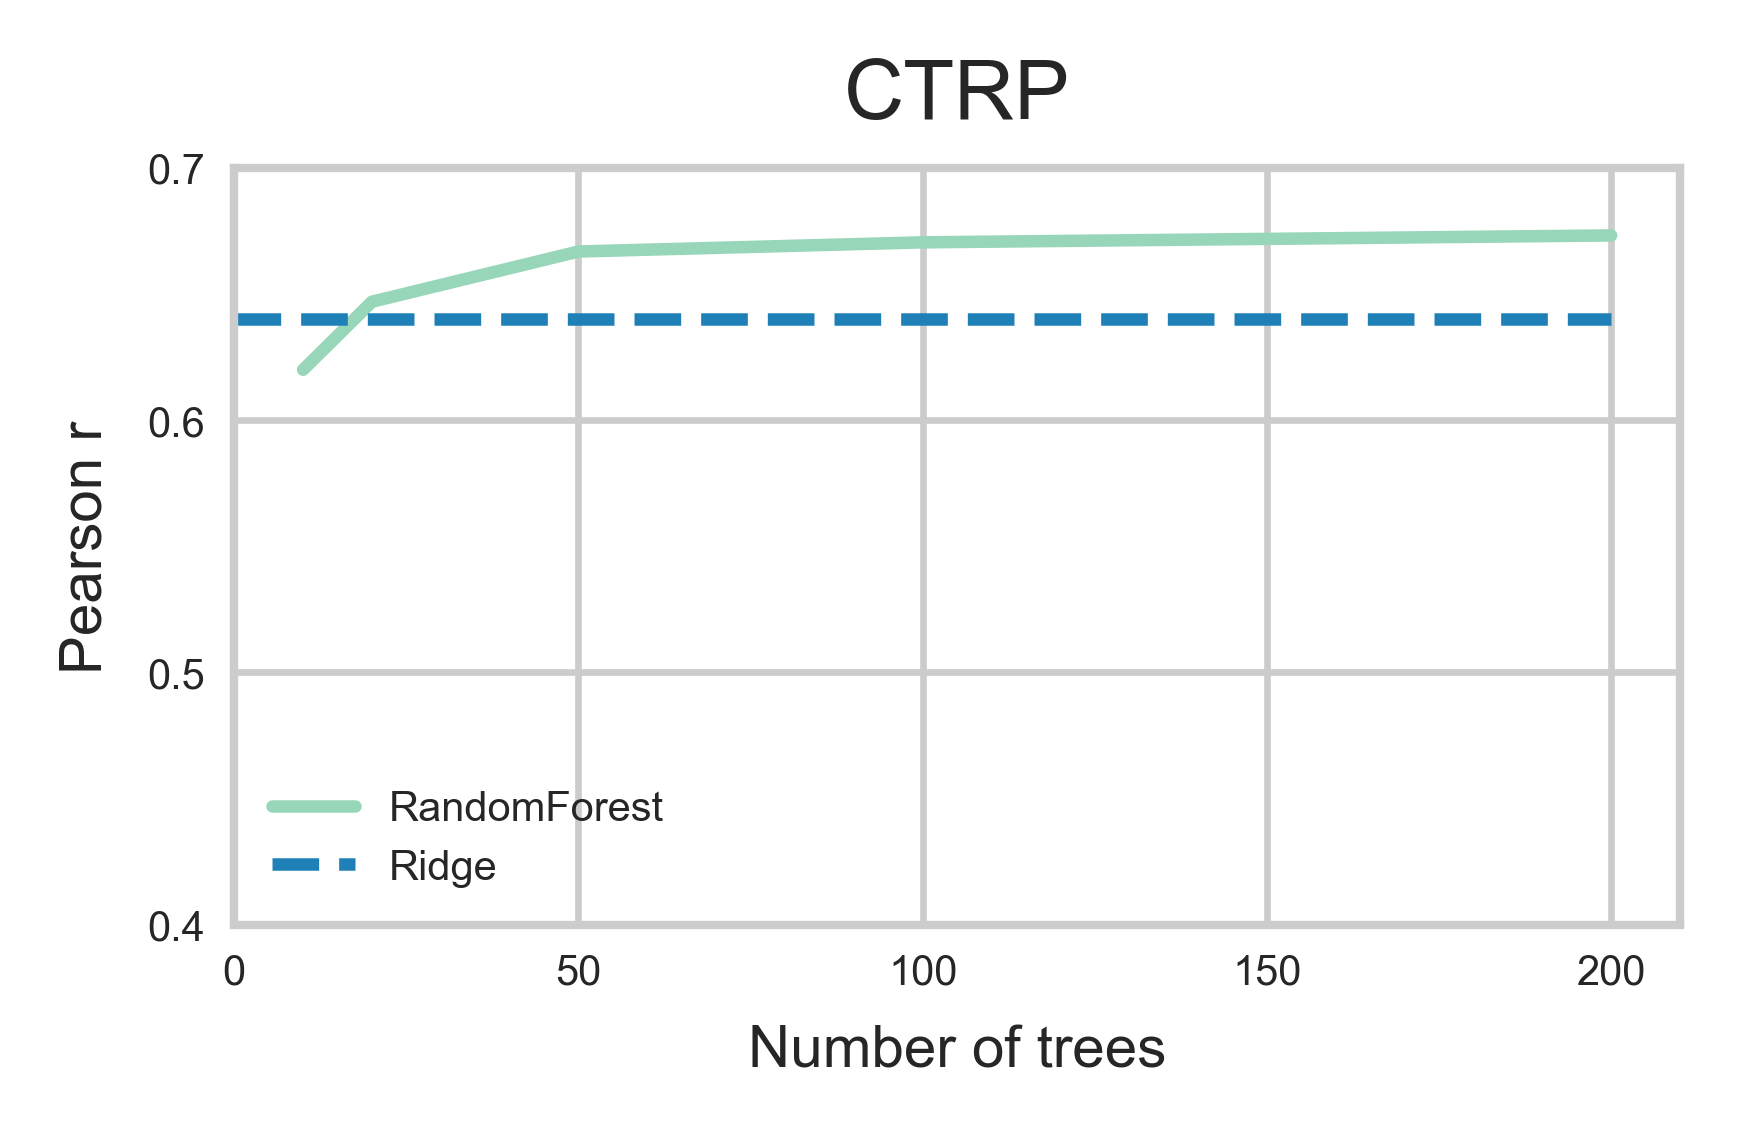

In [130]:
plot_nonlinear_performance('CTRP')

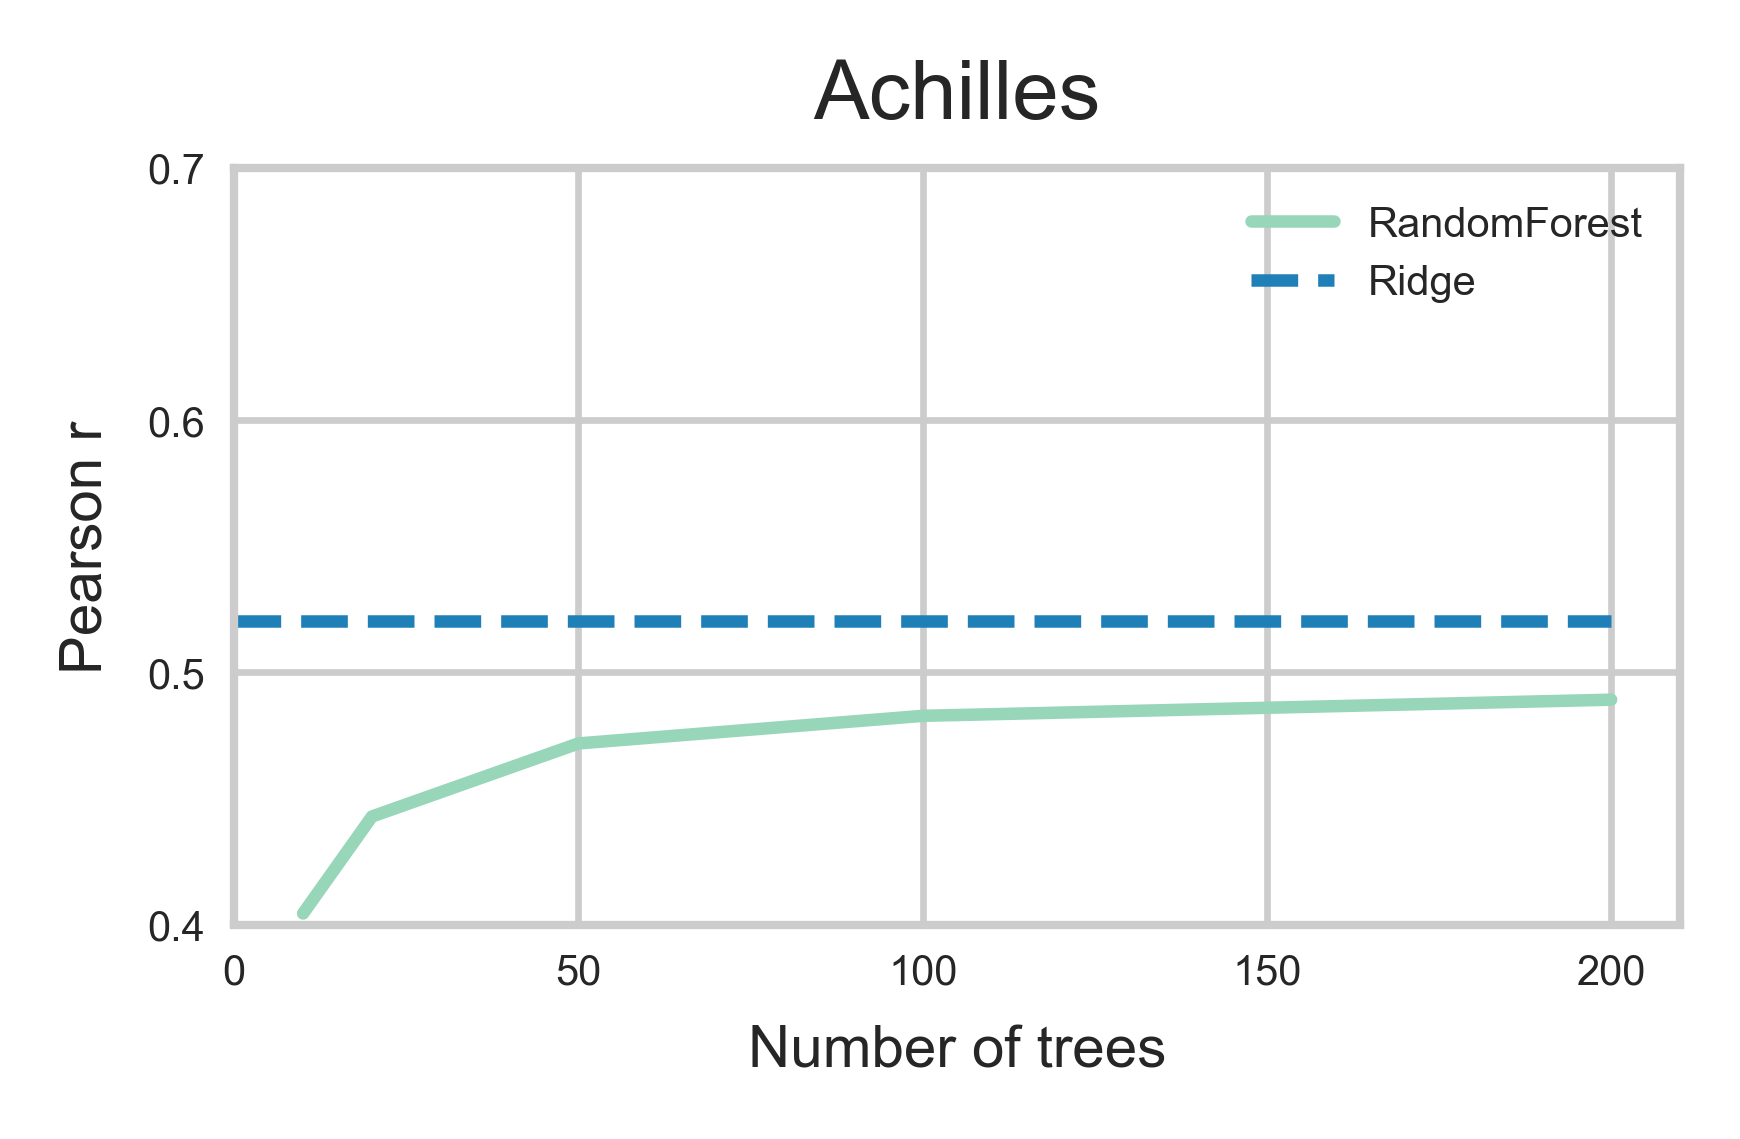

In [131]:
plot_nonlinear_performance('Achilles')

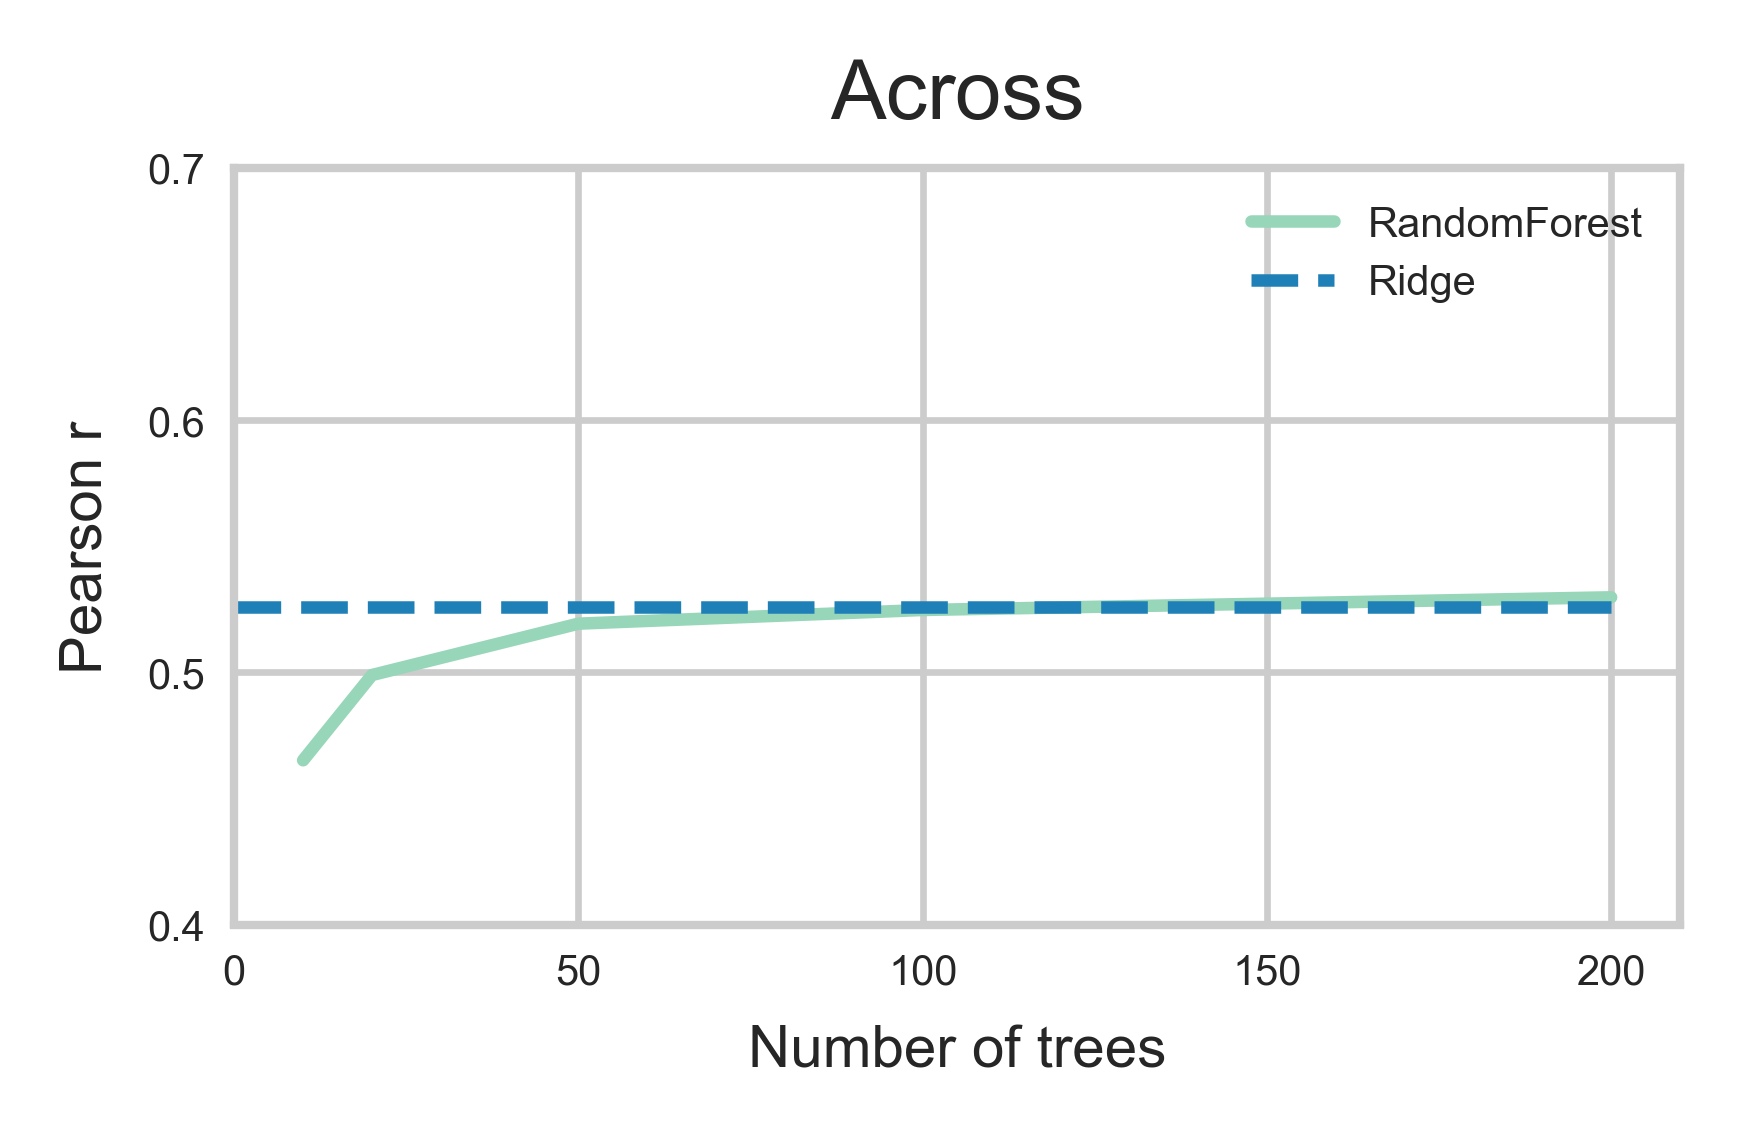

In [132]:
plot_nonlinear_performance('Across')

## Partial correlations between drugs and cell viability signature

In [3]:
scores=pd.read_csv('../results/functional/linear_models/all_scores_lm_pcor.csv',sep=',',header=0,
                  index_col=0)

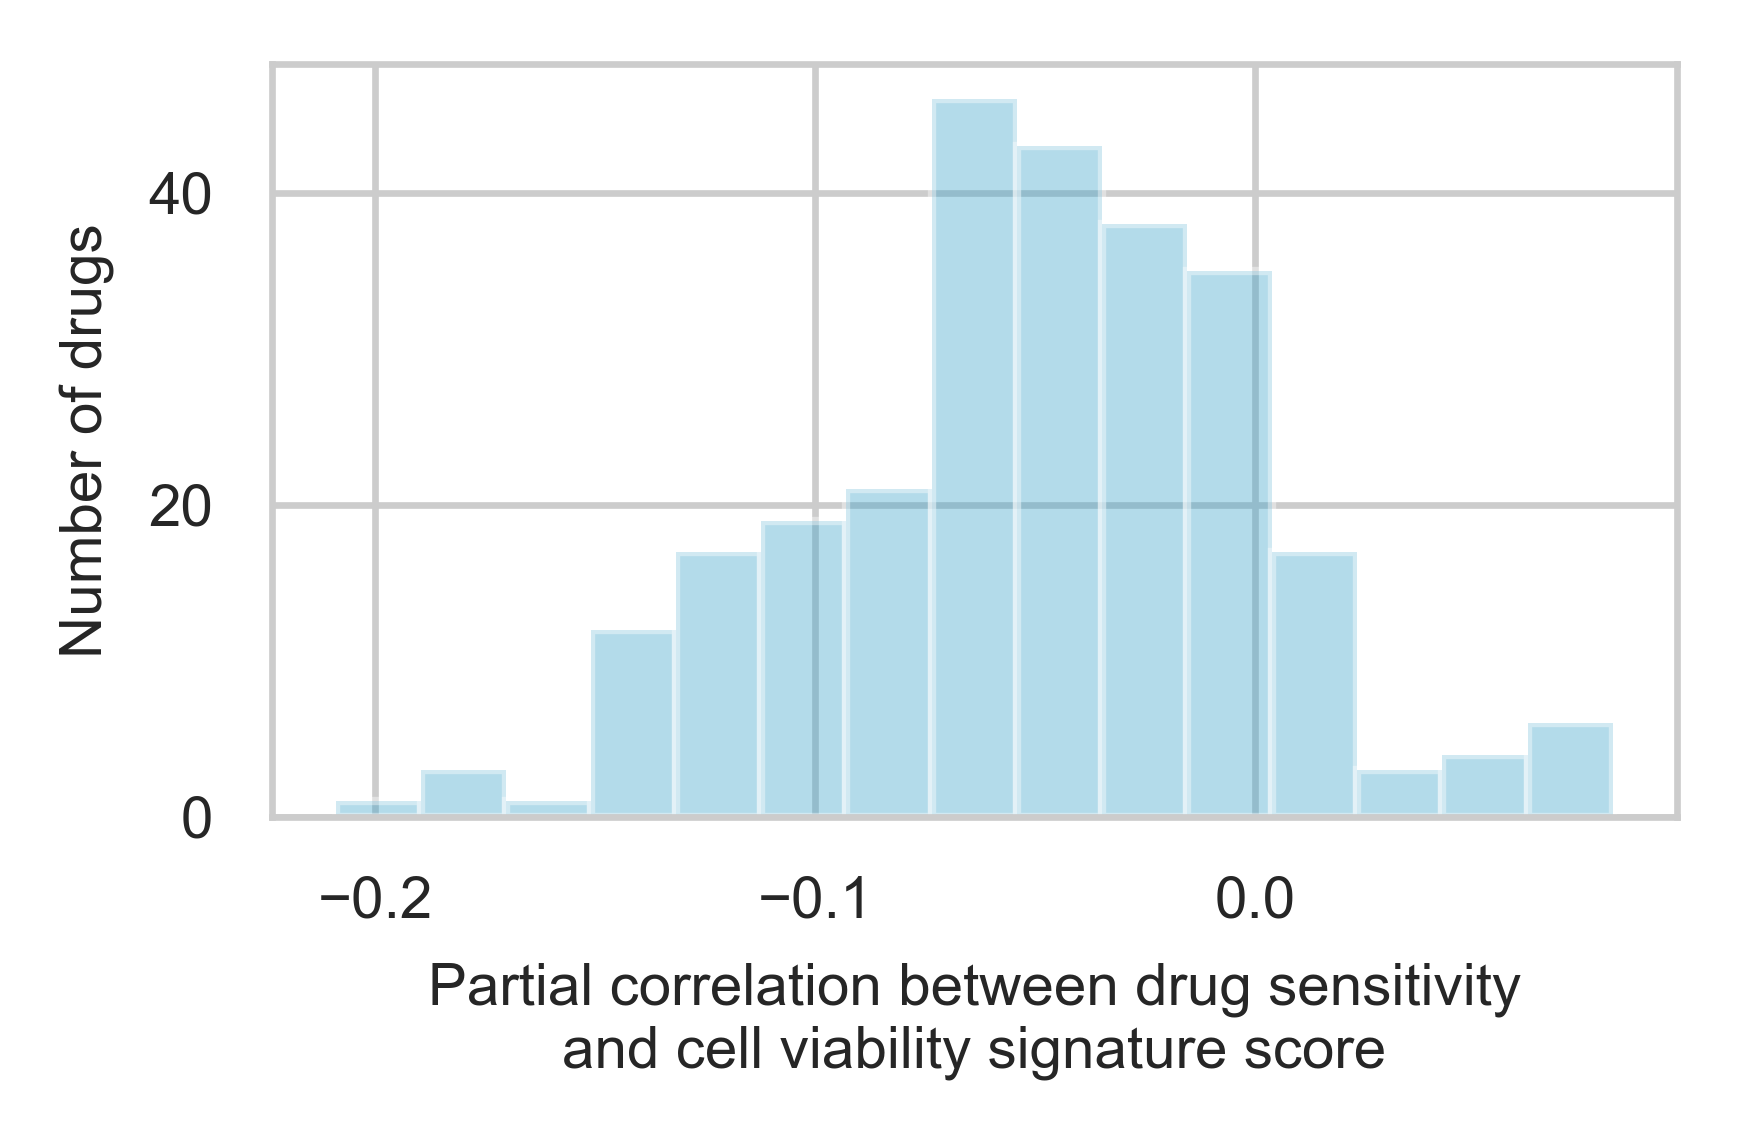

In [10]:
plt.figure(dpi=600,figsize=(3.0,2.0))
sns.set_palette('GnBu_r',2)
sns.distplot(scores['real_model'],kde=False)
plt.xticks(size=7)
plt.yticks(size=7)
plt.ylabel('Number of drugs',size=7)
plt.xlabel('Partial correlation between drug sensitivity\nand cell viability signature score',size=7)
plt.tight_layout()
plt.savefig('../figures/raw/part_cor_sens.pdf')